# Advanced Computer Vision - Logistic Classification
## Diego Pinheiro 
### Contents
1. Logistic Regression
2. Program
3. Experiments

The Equations and Algorithms were adapted from Simon Prince's book and algorithms [1] [2]. 
This work was an assignment requested by Prof. Dr. E. Ribeiro during the class CSE5683 - Computer Vision at Florida Institute of Technology.

## Logistic Regression

The logistic regression regression descriminative model is a statistical classification method defined as:

\begin{equation}
Pr(w|\mathbf{x},\mathbf{\phi}) =  Bern_w \Bigg[ \frac{1}{1 + exp [-\mathbf{\phi^T x_i}]} \Bigg] \enspace .
\end{equation}

Then, the parameter $\mathbf{\phi}$ is estimated using a non-linear minimization according to the following equation:

\begin{equation}
\mathbf{\hat{\phi}} = \operatorname*{arg\,min}_{\mathbf{\phi}} \Bigg[ - \sum_{i=1}^{I} log \bigg[ Bern_{wi} \Big[ \frac{1}{1 + exp [-\mathbf{\phi^T x_i}]} \Big] \bigg] -log \big[ Norm_{\mathbf{\phi}}[\mathbf{0}, \sigma_p^2 \mathbf{I} ]\big] \Bigg]
\end{equation}

## Program

### Used packages 

In [1]:
import scipy.misc as misc
import scipy.special as sp
import scipy.optimize as op
import scipy.stats as stats
from matplotlib.patches import Rectangle
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = 20, 10

### Images initialization

In [2]:
IMAGE_INFO_FILENAME = 'FILENAME'
IMAGE_INFO_POSITIVE_REGION = 'POSITIVE_REGION'
IMAGE_INFO_NEGATIVE_REGION = 'NEGATIVE_REGION'
IMAGE_INFO_RECTANGLE_POSITIVE = 'RECTANGLE_POSITIVE'
IMAGE_INFO_RECTANGLE_NEGATIVE = 'RECTANGLE_NEGATIVE'
IMAGE_INFO_IMAGE = 'IMAGE'

IMAGE_FEATURES_X = 'X'
IMAGE_FEATURES_W = 'W'
IMAGE_FEATURES_VAR_PRIOR = 'VAR_PRIOR'
IMAGE_FEATURES_PHI = 'PHI'
IMAGE_FEATURES_PREDICTIONS = 'PREDICTIONS'
IMAGE_FEATURES_XTEST = 'XTEST'
IMAGE_FEATURES_XTEST_SHAPE = 'X_TEST_SHAPE'
IMAGE_FEATURES_POSTERIOR = 'POSTERIOR'
IMAGE_FEATURES_THRESHOLD = 'THRESHOLD'

IMAGE_PATH = 'images/'

def build_dict(filename, positive_region, negative_region):
    return {IMAGE_INFO_FILENAME: IMAGE_PATH + filename, 
            IMAGE_INFO_RECTANGLE_POSITIVE: positive_region, 
            IMAGE_INFO_RECTANGLE_NEGATIVE: negative_region}

images_info = dict()
images_info['WINSLET'] = build_dict('winslet.jpg',[ 257,  131,   33,  224 ], [ 49,   92,   51,  164 ])
images_info['LENA'] = build_dict('lena.png', [302,222,16,156], [34,15,58,71])
images_info['DIEGO'] = build_dict('diego.jpg',[332,131,16,241], [65,48,83,375])
images_info['ERIKA'] = build_dict('erika.jpg',[260,128,28,233], [29,237,115,416])

image_keys = ['WINSLET', 'LENA', 'DIEGO','ERIKA']


### Positive and Negative Regions

In [3]:
for image_key in image_keys:
    image_info = images_info[image_key]
    image_filename = image_info[IMAGE_INFO_FILENAME]
    image = misc.imread(image_filename)

    rect_positive = image_info[IMAGE_INFO_RECTANGLE_POSITIVE]
    rect_negative = image_info[IMAGE_INFO_RECTANGLE_NEGATIVE]

    positive_region = image[rect_positive[1]:(rect_positive[1]+rect_positive[3]),
                            rect_positive[0]:(rect_positive[0]+rect_positive[2])]
    negative_region = image[rect_negative[1]:(rect_negative[1]+rect_negative[3]), 
                            rect_negative[0]:(rect_negative[0]+rect_negative[2])]
    
    image_info[IMAGE_INFO_IMAGE] = image
    image_info[IMAGE_INFO_POSITIVE_REGION] = positive_region
    image_info[IMAGE_INFO_NEGATIVE_REGION] = negative_region

### Images and their respective positive and negative regions

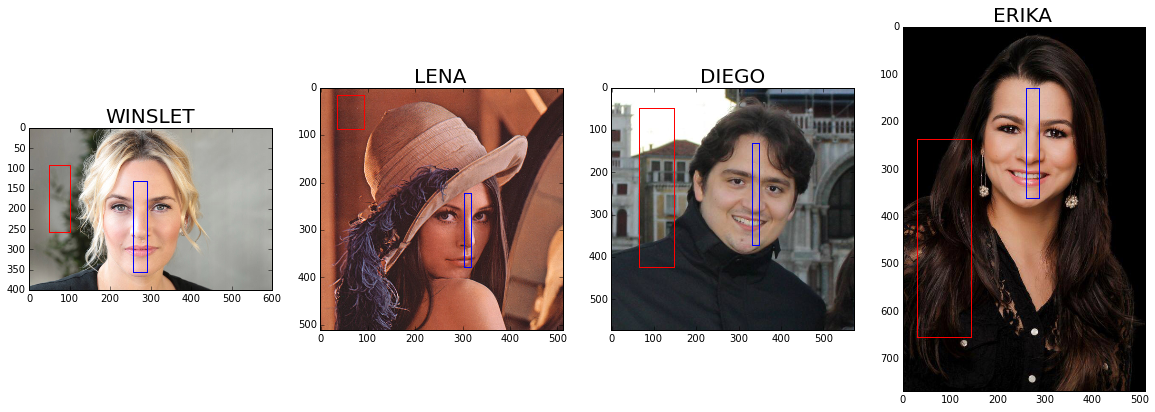

In [4]:
fig = plt.figure()

i = 1
for image_key in image_keys:
    image_info = images_info.get(image_key)
    image = image_info[IMAGE_INFO_IMAGE]
    rect_positive = image_info[IMAGE_INFO_RECTANGLE_POSITIVE]
    rect_negative = image_info[IMAGE_INFO_RECTANGLE_NEGATIVE]
    ax = fig.add_subplot(1,4,i)
    ax.imshow(image)
    ax.set_title(image_key, size=20)
    currentAxis = plt.gca()
    currentAxis.add_patch(Rectangle((rect_positive[0], rect_positive[1]), 
                                    rect_positive[2], rect_positive[3], 
                                    edgecolor='b', facecolor='None', color=None, alpha=1))
    currentAxis.add_patch(Rectangle((rect_negative[0], rect_negative[1]), 
                                    rect_negative[2], rect_negative[3], 
                                    edgecolor='r', facecolor='None', color=None, alpha=1))
    i += 1
    
plt.show()

### Initialization of Training Data

In [5]:
for image_key in image_keys:
    image_info = images_info.get(image_key)
    negative_region = image_info[IMAGE_INFO_NEGATIVE_REGION]
    positive_region = image_info[IMAGE_INFO_POSITIVE_REGION]

    N = 300
    r0 = negative_region[:, :, 0]
    r0 = np.random.choice(r0.ravel(), size=N).reshape((1, N))

    r1 = positive_region[:, :, 0]
    r1 = np.random.choice(r1.ravel(), size=N).reshape((1, N))

    X = np.c_[r0, r1]
    X = np.r_[np.ones((1, N + N)), X]
    W = np.r_[np.zeros((N, 1)), np.ones((N,1))]
    
    var_prior = np.var(r1)
    
    image_info[IMAGE_FEATURES_X] = X
    image_info[IMAGE_FEATURES_W] = W
    image_info[IMAGE_FEATURES_VAR_PRIOR] = var_prior

### Optimization Process

#### Objective Function: Cost

In [6]:
def fit_logr_cost(phi, X, w, var_prior):
    phi = phi.reshape(1,phi.shape[0])
    I = X.shape[1]
    D = X.shape[0] - 1

    L = I * ( - np.log(stats.multivariate_normal.pdf(x=phi, mean=np.zeros(D+1)+1, 
                                                     cov=var_prior*np.eye(D+1))))

    predictions = sp.expit(phi.dot(X))

    for i in range(0, I):
        y = predictions[0, i]
        if w[i] == 1:
            L = L - np.log(y)
        else:
            L = L - np.log(1 - y)

    phi.shape = (phi.shape[1],)
    return L

#### Objective Function: Gradient

In [7]:
def fit_logr_gradient(phi, X, w, var_prior):
    phi = phi.reshape(phi.shape[0], 1)
    I = X.shape[1]
    g = I * phi / var_prior

    predictions = sp.expit(phi.T.dot(X))

    for i in range(0, I):
        y = predictions[0, i]
        x_i = np.c_[X[:, i]]
        g += (y - w[i]) * x_i

    phi.shape = (phi.shape[0],)

    return g.ravel()

#### Objective Function: Hessian

In [8]:
def fit_logr_hessian(phi, X, w, var_prior):
    phi = phi.reshape(phi.shape[0], 1)
    I = X.shape[1]
    D = X.shape[0] - 1
    H = I * np.diagflat(np.tile(var_prior, (1, D+1)))

    predictions = sp.expit(phi.T.dot(X))

    for i in range(0, I):
        y = predictions[0, i]

        x_i = np.c_[X[:, i]]
        H += y * (1-y) * (x_i.dot(x_i.T))

    return H

#### Optimization Encapsulation using Newton-CG method

In [9]:
def fit_logr(X, w, var_prior, initial_phi):
    objective_function = (lambda phi: fit_logr_cost(phi, X, w, var_prior))
    gradient = (lambda phi: fit_logr_gradient(phi, X, w, var_prior))
    hessian = (lambda phi: fit_logr_hessian(phi, X, w, var_prior))
    result = op.minimize(fun=objective_function, x0=initial_phi, 
                         jac=gradient, hess=hessian, method='Newton-CG')
    phi = result.x
    return phi

### Calculation of Parameters $\mathbf{\phi}$

In [10]:
for image_key in image_keys:
    image_info = images_info.get(image_key)
    X = image_info[IMAGE_FEATURES_X]
    W = image_info[IMAGE_FEATURES_W]
    var_prior = image_info[IMAGE_FEATURES_VAR_PRIOR]
    
    initial_phi = np.r_[0.0, 0.0]
    phi = fit_logr(X, W, var_prior, initial_phi)    
    
    image_info[IMAGE_FEATURES_PHI] = phi

### Logistic Regression Model Fitted to Two Different Classes

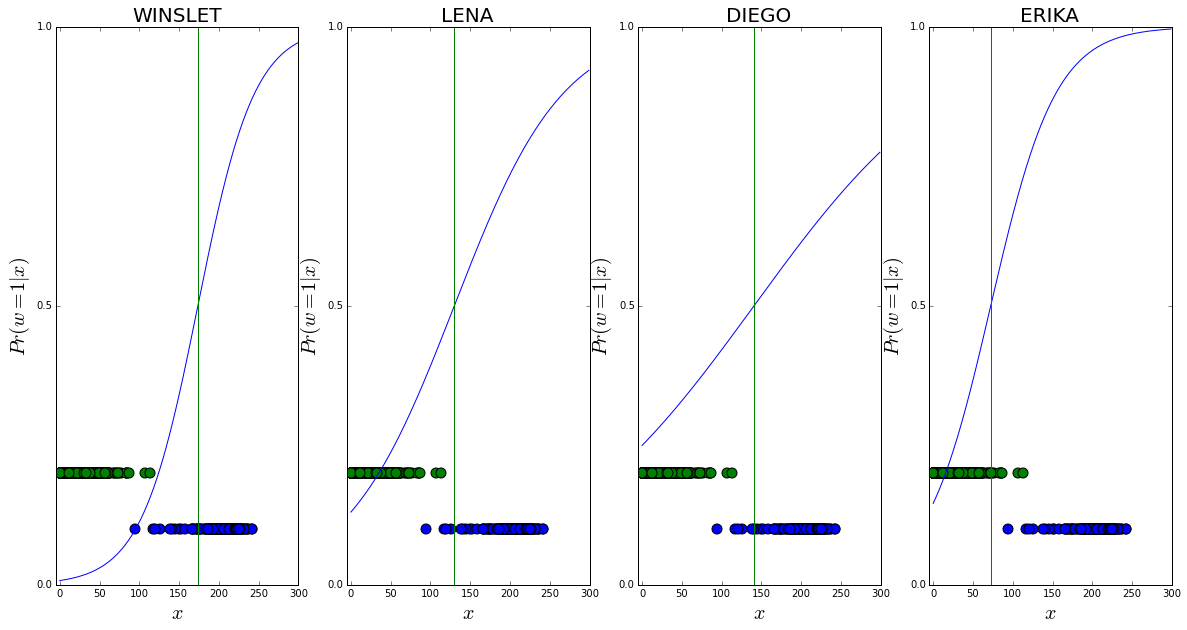

In [11]:
fig = plt.figure()
i = 1

for image_key in image_keys:
    image_info = images_info.get(image_key)
    x_test = np.arange(0, N).reshape(1, N)
    x_test = np.r_[np.ones((1, x_test.shape[1])), x_test]
    
    phi = image_info[IMAGE_FEATURES_PHI]
    
    predictions = sp.expit(phi.T.dot(x_test))
    decision_boundary = -phi[0] / phi[1]
    
    image_info[IMAGE_FEATURES_PREDICTIONS] = predictions
    
    ax = fig.add_subplot(1,4,i)
    ax.scatter(r0, np.zeros((1, N)) + 0.2, s=100, c='g', marker='o')
    ax.scatter(r1, np.zeros((1, N)) + 0.1, s=100, c='b', marker='o')
    ax.plot(range(0,N), predictions)
    ax.plot(np.tile(decision_boundary, 10), np.linspace(0, 1, 10))
    ax.set_xlim(-5, N)
    ax.set_ylim(0, 1)
    #ax1.set_xticks([-5, 0, 5])
    ax.set_yticks([0, 0.5, 1])
    ax.set_title(image_key, size=20)
    ax.set_xlabel('$x$', size=20)
    ax.set_ylabel('$Pr(w=1|x)$', size=20)
    i += 1
plt.show()

### The posterior $Pr(w = 1| x)$ applied to the Images

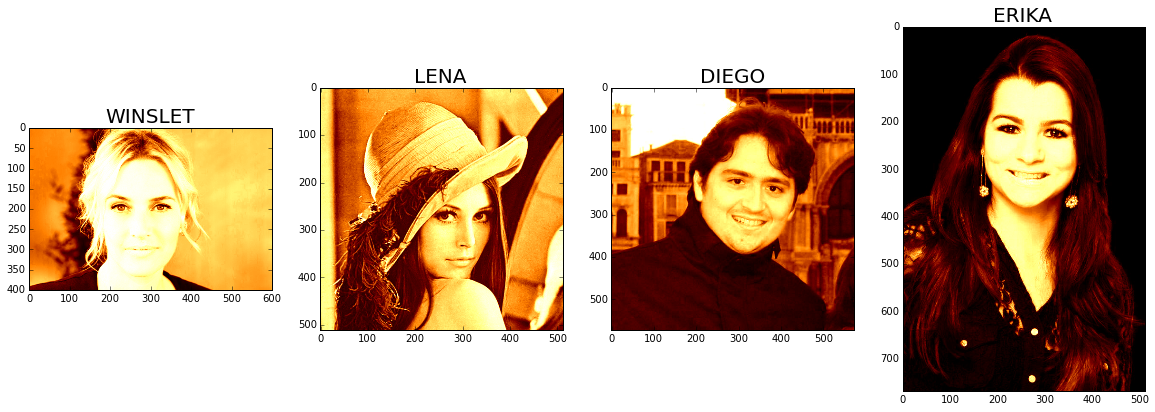

In [12]:
fig = plt.figure()
i = 1
for image_key in image_keys:    
    image_info = images_info.get(image_key)
    predictions = image_info[IMAGE_FEATURES_PREDICTIONS]
    image = image_info[IMAGE_INFO_IMAGE]
    x_test = misc.imresize(image[:, :, 0], 100)
    x_test_shape = x_test.shape
    x_test = x_test.ravel()
    x_test = x_test.reshape(1, x_test.shape[0])
    posterior = predictions[x_test]
    
    image_info[IMAGE_FEATURES_XTEST] = x_test
    image_info[IMAGE_FEATURES_XTEST_SHAPE]= x_test_shape
    image_info[IMAGE_FEATURES_POSTERIOR] = posterior
    
    ax1 = fig.add_subplot(1,4,i)
    ax1.imshow(x_test.reshape(x_test_shape), cmap=cm.afmhot)
    ax1.set_title(image_key,size=20)
    i += 1
plt.show()

### Threshold $th$ for each Image

In [13]:
images_info['WINSLET'][IMAGE_FEATURES_THRESHOLD] = 0.8
images_info['LENA'][IMAGE_FEATURES_THRESHOLD] = 0.6
images_info['DIEGO'][IMAGE_FEATURES_THRESHOLD] = 0.5
images_info['ERIKA'][IMAGE_FEATURES_THRESHOLD] = 0.90

### Thresholded posterior $Pr(w = 1 | x) > th$ applied to each Image

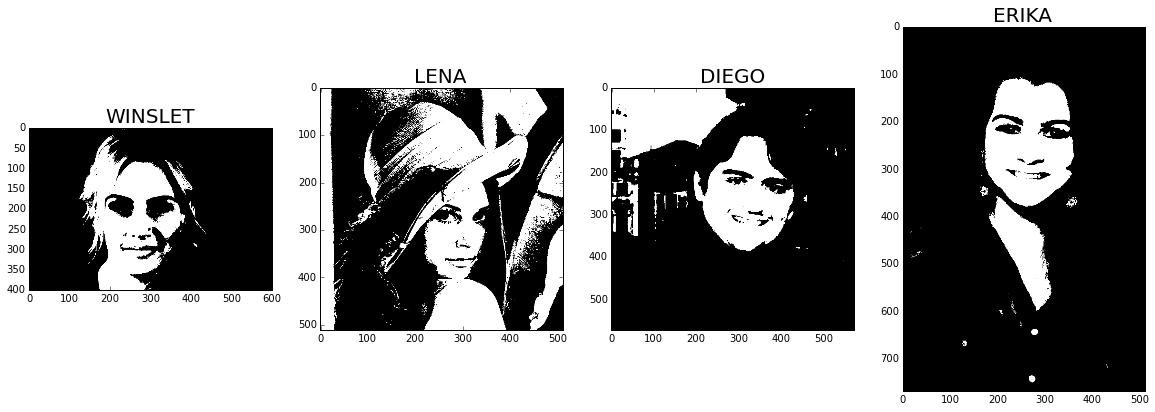

In [14]:
fig = plt.figure()
i = 1
for image_key in image_keys: 
    image_info = images_info.get(image_key)
    posterior = image_info[IMAGE_FEATURES_POSTERIOR]
    threshold = image_info[IMAGE_FEATURES_THRESHOLD]
    x_test_shape = image_info[IMAGE_FEATURES_XTEST_SHAPE]
    
    ax1 = fig.add_subplot(1,4,i)
    ax1.imshow((posterior > threshold).reshape(x_test_shape), cmap=cm.afmhot)
    ax1.set_title(image_key, size=20)
    i += 1
plt.show()

## Results
The effectiveness of the model was moderate for some images and not satisfactory for other images.
The results were reasonably for WINSLET and ERIKA image since the skin pixels and non-skin pixels are relatively well distinguished. However, some pixels belonging to the hair region were misclassified as skin for WINSLET image and some shirt buttons and earrings were misclassified as skin for ERIKA image.

On the other hand, the model performed poorly for DIEGO and LENA images since background information was significantly misclassified as skin. 

## Restrictions
The most restrictive characteristic of this model is the utilization of the RGB red channel only. A more suitable approach would consider using all the three channels. 

## References 
[1] Prince, S. J. D. (2012). Computer Vision: Models Learning and Inference. Cambridge University Press.

## External links
[1] Website of Computer Vision:  Models, Learning, and Inference  Webhttp://www.computervisionmodels.com/

[2] Website of Dr. E. Ribeiro -  http://cs.fit.edu/~eribeiro/Eraldo_Ribeiro/Eraldo_Ribeiro.html

[3] Machine Learning with Python - Linear Regression -  http://aimotion.blogspot.com/2011/10/machine-learning-with-python-linear.html

[3] Fernando Pérez, Brian E. Granger, IPython: A System for Interactive Scientific Computing, Computing in Science and Engineering, vol. 9, no. 3, pp. 21-29, May/June 2007, doi:10.1109/MCSE.2007.53. URL: http://ipython.org


## Acknowledgements

Hugo Barbosa-Filho, for all incentive to use python.

Thiago Gonçalves Mendonça and Shayesteh Ghaderpour, for all fruitful collaboration.
